In [1]:
%run ./tools.ipynb

In [2]:
# inversion configurations
year        = 2018
assim_month = 4   # month to assimilate observation, start from 3, Mar
lag_window  = 3    # months
nx          = 22   # number of tagged tracers, same as number of masks
mask_type   = 'giorgi' # world mask, splits global into 22 regions
mode        = 'N' # OCO-2 Nadir only
mod_err     = 1.5 # model/transport error, unit: ppm
prior_err   = 0.5 # intial prior error, unitless, multiply biospheric flux for actual prior error

# total CO2 simulation directory
top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/'
mod_dir = top_dir + 'CO2-updated-' + str(year) + '/nd51/' + short_name_of_month(assim_month) + '/'


In [3]:
%run bio_flux_functions.ipynb

# biospheric flux, same as above, except resolution, following is used in model simulations, above is regridded
if assim_month == 3: fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.nc'
else: fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.updated.' + short_name_of_month(assim_month-1) + '.nc'

monthly_bio_flux = regional_monthly_bio(fname)
#monthly_bio_flux

finished creating masks for giorgi
Biospheric annual flux (PgC/year):  0.18912672811716558


In [4]:
# prior error
del_X_f = np.diag(np.repeat(prior_err,22))
del_X_f[1,1] = 0.75 # Amazon basin
del_X_f[5,5] = 0.2  # Central North America
del_X_f[6,6] = 1.   # Eastern North America
del_X_f[7,7] = 0.2  # Alaska 
del_X_f[8,8] = 0.1  # Greenland
del_X_f[11,11] = 1. # Western Africa
del_X_f[12,12] = 1. # Eastern -
del_X_f[13,13] = 1. # Southern
del_X_f[15,15] = 1. # Southest Asia
del_X_f[19,19] = 1.  # North Asia
del_X_f[20,20] = 0.1 # North Asia
del_X_f[21,21] = 1.  # Ocean
print('initial: ', np.diag(del_X_f))

# make scaling maps for each month
#error_map = dr_monthly[0,:,:].copy()
#error_map[:,:] = 0. # scale map, [lag_window, lat, lon]

#for ilat in range(len(error_map.lat)):
#    for ilon in range(len(error_map.lon)):
#        if np.isnan(mask[ilat,ilon].values): error_map[ilat,ilon] = del_X_f[21,21] # last one, ocean
#        else: 
#            mask_nm = int(mask[ilat,ilon].values)
#            error_map[ilat,ilon] = del_X_f[mask_nm-1, mask_nm-1] # mask number from 1 to 21


initial:  [0.5  0.75 0.5  0.5  0.5  0.2  1.   0.2  0.1  0.5  0.5  1.   1.   1.
 0.5  1.   0.5  0.5  0.5  1.   0.1  1.  ]


In [5]:
#error_map.plot(vmax = 1, vmin = 0,
#                    cmap = 'RdBu_r',
#                    add_labels = False,
#cbar_kwargs={'shrink': 1})

In [6]:
# prior error, read in from previous assimilation (if any)
if assim_month > 3:
    del_X_lag = np.loadtxt(mod_dir + "prior_error_" + short_name_of_month(assim_month-1) + ".txt")
else:
    del_X_lag = np.zeros((nx*lag_window,nx*lag_window))
    for i in range(lag_window): del_X_lag[i*nx:(i+1)*nx,i*nx:(i+1)*nx] = del_X_f #[nx*nlag, nx*nlag], diag,
print('actual:', np.diag(del_X_lag))

actual: [0.47408598 0.64558593 0.48840111 0.49698041 0.49074355 0.1982166
 0.94177511 0.19991201 0.09998325 0.49356478 0.48721831 0.95942877
 0.99403824 0.76148278 0.49999937 0.99864703 0.47311226 0.4830756
 0.495855   0.98209973 0.09968257 0.99592402 0.44909633 0.46515561
 0.40813152 0.48065267 0.4581866  0.19572281 0.88005628 0.19997928
 0.09997728 0.48471111 0.47594636 0.86189912 0.66089961 0.39744028
 0.49993347 0.88372265 0.42165728 0.42733603 0.49449456 0.93212658
 0.09903969 0.99855739 0.5        0.75       0.5        0.5
 0.5        0.2        1.         0.2        0.1        0.5
 0.5        1.         1.         1.         0.5        1.
 0.5        0.5        0.5        1.         0.1        1.        ]


Feb adjustment: 0.58
Mar adjustment: 0.39
Apr adjustment: 0.09
y diff before: -1.18
y diff after: -0.26


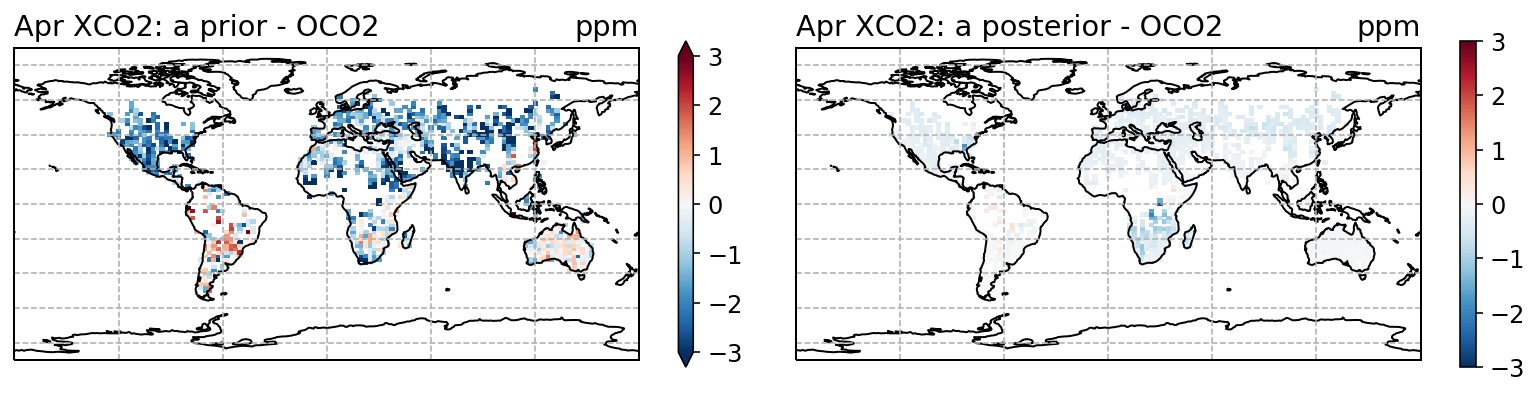

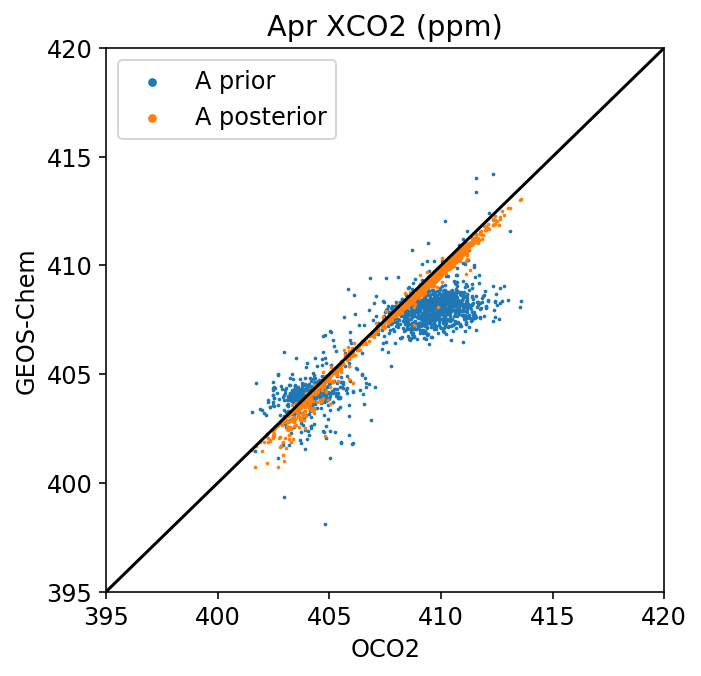

In [7]:
# start of inversion calculation:
# 1, read in from full CO2 simulations
name_month = short_name_of_month(assim_month) # Jan, Feb, Mar, ...
xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
ds_xco2 = xr.open_dataset(mod_dir + xco2_file)
xco2_oco2  = ds_xco2['xco2_oco2']  # XCO2 from OCO-2
xco2_model = ds_xco2['xco2_model'] # XCO2 from model
xco2_error = ds_xco2['xco2_error'] # measurement error from OCO-2
diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
# reduce the size of above arrays and matrices, from ~400k to <3k
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values   # index for slicing
nobs = len(ind) # number of obs in this month
# get slices of arrays
diff_slice = diff[ind].values            # [nobs], 1-3k per month
lat_slice = ds_xco2.lat[ind]
lon_slice = ds_xco2.lon[ind]
xco2_mod_slice = xco2_model[ind]
xco2_oco_slice = xco2_oco2[ind]
xco2_error_slice = xco2_error[ind].values 
# observation error
obs_error = np.zeros((nobs,nobs))  # [nobs,nobs], diagonally store obs error
for idiag in range(nobs):
    obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + mod_err**2
    # measurment error from oco2
    # model error and representation error = 2.5 for land
        
# delta y0
del_Y = np.empty((nobs,nx*lag_window))   # [nobs, nx*lag_window]
del_Y[:] = np.nan

# 2, read in tag runs
for itmp in range(lag_window):
    ilag_month = assim_month - lag_window + itmp + 1
    ens_dir = top_dir + 'CO2-casa-2018-' + month_string(ilag_month) + '/nd51/'
    delta_y0_file = 'delta_y0_model_N_' + str(assim_month) + '.nc'
    # open datasets
    ds_delta_y0 = xr.open_dataset(ens_dir + delta_y0_file)
    varnames = list(ds_delta_y0.data_vars.keys())  # list of variable name
    needed_vars = [i for i in varnames if i.startswith('X_SpeciesConc_CO2Tag')] # species var names
    # read variables
    for itag, ivar in enumerate(needed_vars):
        del_Y[:,itag+nx*itmp] = ds_delta_y0[ivar][ind].values # column order: assim_month - 2, assim_month - 1, assim_month

# temporal lines to explore del_Y
#tmp = del_Y.min(axis=0)
#tmp1 = tmp.reshape(lag_window, nx)
#for i in range(lag_window): 
#    plt.plot(tmp1[i], label=short_name_of_month(i+1))
#plt.legend()

del_Y = np.dot(del_Y, del_X_lag)   
# calculation of posterior
del_Y_tran = np.matrix.transpose(del_Y)     # del_y transpose [nx*lag_window,nobs]
first      = np.matmul(del_Y,del_Y_tran)    # del_y dot del_y_tran [nobs,nobs]
second     = np.linalg.inv(first+obs_error) # (Y*Yt + R)^-1 [nobs,nobs], dominated by second term, issue???
third      = np.matmul(del_Y_tran,second)   # Yt*(Y*Yt + R)^-1 [nx*lag_window,nobs]
k_e        = np.matmul(del_X_lag,third)     # kalman gain, k_e = X_f*Yt*(Y*Yt + R)^-1 [nx*lag_window,nobs]
adjust     = np.matmul(k_e, diff_slice)     # adjustment to prior, k_e*(yobs - ym)  [nx*lag_window]

update = adjust * monthly_bio_flux[assim_month-lag_window:assim_month].flatten()
# monthly updates
for i in range(lag_window):
    print(short_name_of_month(assim_month - lag_window + i + 1), 'adjustment: {:.2f}'.format(sum(update[i*nx:(i+1)*nx])))

# update Y matrix
diff_new = np.dot(del_Y,adjust) # [nobs], ppm
plot_xco2_diff(diff_slice, diff_new, lat_slice, lon_slice, assim_month)

# transformation matrix to update prior
fourth = np.identity(nx*lag_window) - np.matmul(third, del_Y)
transform_mat = sp.sqrtm(fourth)
del_X_lag = np.matmul(del_X_lag, transform_mat)

# update del_X_lag and use it in next assimilation
del_X_updated = np.zeros((nx*lag_window,nx*lag_window))
del_X_updated[:(lag_window-1)*nx, :(lag_window-1)*nx] = del_X_lag[nx:,nx:]
del_X_updated[(lag_window-1)*nx:, (lag_window-1)*nx:] = del_X_f


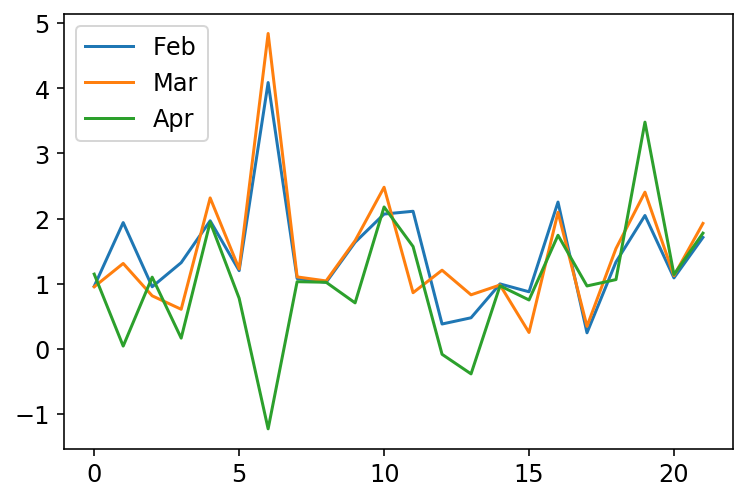

In [8]:
# use this to update biospheric flux in total CO2 simulations
scale_array = 1+adjust
scale_lag = scale_array.reshape(lag_window,nx) # 2d

#scale_lag = np.flip(scale_lag, axis = 0) # flip?

for i in range(lag_window): 
    plt.plot(scale_lag[i], label = short_name_of_month(assim_month - lag_window + i + 1))
plt.legend()

In [9]:
# make a mask matching flux grid
# biospheric flux, same as above, except resolution, following is used in model simulations, above is regridded
if assim_month == 3: fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.nc'
else: fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.updated.' + short_name_of_month(assim_month-1) + '.nc'

ds = xr.open_dataset(fname)
data = ds['CO2'].copy()

# create masks for this resolution
dr = data[0,:,:]
# create masks for input file
mask = create_masks(input_file=dr, 
                    input_file_type='dataarray', 
                    var_name='', 
                    mask_type='giorgi', 
                    output_format='xarray', 
                    output_path='/geos/u73/msadiq/GEOS-Chem/MASKS/nc/giorgi/', 
                    figure_flag = False, 
                    figure_path='/home/msadiq/Desktop/co2/data/emission/MASKS/figures/')

finished creating masks for giorgi


In [10]:
%%time
# make scaling maps for each month
scale_map = ds['CO2'][0:lag_window,:,:].copy()
scale_map[:,:,:] = 0. # scale map, [lag_window, lat, lon]

for imonth in range(lag_window):
    for ilat in range(len(scale_map.lat)):
        for ilon in range(len(scale_map.lon)):
            if np.isnan(mask[ilat,ilon].values): scale_map[imonth,ilat,ilon] = scale_lag[imonth,21] # last one, ocean
            else: 
                mask_nm = int(mask[ilat,ilon].values)
                scale_map[imonth,ilat,ilon] = scale_lag[imonth,mask_nm-1] # mask number from 1 to 21


KeyboardInterrupt: 

In [11]:
# monthly biospheric flux
dr_casa = monthly_bio(fname)


finished creating masks for giorgi


In [ ]:
# multiply this scale map to bio flux
# plot updates during lag window
fig, axes = plt.subplots(3, 2, 
                         figsize=[14, 14], 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'hspace': 0.2, 'wspace': 0})

# monthly biospheric flux
for i in range(lag_window):
    
    dr_casa[assim_month - lag_window + i,:,:].plot(ax=axes[i,0], 
                    vmax = 8e8,
                    vmin = -8e8,
                    cmap = 'RdBu_r',
                    add_labels = False,
                    cbar_kwargs={'shrink': 0.8})
    axes[i,0].set_title(long_name_of_month(assim_month - lag_window + i + 1), loc='left')
    axes[i,0].set_title('biospheric flux', loc='right')
    axes[i,0].coastlines()
    axes[i,0].gridlines(linestyle = '--')
    
# adjustments
for i in range(lag_window):
    adjust_abs = dr_casa[assim_month - lag_window + i,:,:]*(scale_map[i,:,:]-1)
    adjust_abs.plot(ax = axes[i,1],
                            vmax = 8e8,
                            vmin = -8e8,
                            cmap = 'RdBu_r',
                            add_labels = False,
                            cbar_kwargs={'shrink': 0.8})

    axes[i,1].set_title(long_name_of_month(assim_month - lag_window + i + 1), loc='left')
    axes[i,1].set_title('adjustment', loc='right')
    axes[i,1].coastlines()
    axes[i,1].gridlines(linestyle = '--')
    
fig.savefig(mod_dir  + 'flux_scaling.' + short_name_of_month(assim_month) + '.update.png', dpi = 300)


In [ ]:
months = np.arange('2016-01', '2017-02', dtype='datetime64[M]')
for i in range(lag_window):
    imonth = assim_month - lag_window + i
    print(months[imonth])
    before = data.sel(time = slice(months[imonth], months[imonth+1]))
    after = data.sel(time = slice(months[imonth], months[imonth+1]))*scale_map[i,:,:]
    #after = data.sel(time = slice(months[imonth], months[imonth+1]))*10 # testing
    # assign this new subset into dataarray
    time_dim = before.time
    data.loc[dict(time = time_dim)] = after
    

In [ ]:
# outputs
# 1, updated biospheric fluxes
ds_output = data.to_dataset(name = 'CO2')
ds_output.attrs = ds.attrs
ds_output.to_netcdf('/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.updated.' +
                     short_name_of_month(assim_month) + 
                     '.nc')
# 2, updated prior error, save it in current and next month directory
np.savetxt(mod_dir + "prior_error_" + short_name_of_month(assim_month) + ".txt", del_X_updated)
next_dir = top_dir + 'CO2-updated-' + str(year) + '/nd51/' + short_name_of_month(assim_month+1) + '/'
np.savetxt(next_dir + "prior_error_" + short_name_of_month(assim_month) + ".txt", del_X_updated)


In [ ]:
# check error
a = np.loadtxt(mod_dir + "prior_error_" + short_name_of_month(assim_month) + ".txt")
np.diag(a)

In [ ]:
# modify config files in the simulations, for next cycle
# only works when assim_month >= 4
datestring1 = str(year) + month_string(assim_month - lag_window ) + '01'
datestring2 = str(year) + month_string(assim_month + 1) + '01'
datestring3 = str(year) + month_string(assim_month - lag_window + 1) + '01'
datestring4 = str(year) + month_string(assim_month + 2) + '01'
datestring1, datestring2, datestring3, datestring4

In [ ]:
fname = mod_dir[:-9] + 'input.geos'
reading_file = open(fname, "r")
new_file_content = ""
for line in reading_file:
    stripped_line = line.strip()
    if datestring1 in stripped_line: 
        new_line = stripped_line.replace(datestring1, datestring3)
    elif datestring2 in stripped_line:
        new_line = stripped_line.replace(datestring2, datestring4)
    else: new_line = stripped_line
    new_file_content += new_line +"\n"
reading_file.close()

print(new_file_content)
# does not work
#writing_file = open(fname, "w")
#writing_file.write(new_file_content)
#writing_file.close()


In [ ]:
string1 = 'NEE.Liang.2016.updated.' + short_name_of_month(assim_month-1)+ '.nc'
string2 = 'NEE.Liang.2016.updated.' + short_name_of_month(assim_month)+ '.nc'
string1, string2

In [ ]:
fname = mod_dir[:-9] + 'HEMCO_Config.rc'
reading_file = open(fname, "r")
new_file_content = ""
for line in reading_file:
    stripped_line = line.strip()
    if string1 in stripped_line: 
        new_line = stripped_line.replace(string1, string2)
        print(new_line)
    else: new_line = stripped_line
    new_file_content += new_line +"\n"
reading_file.close()

#writing_file = open(fname, "w")
#writing_file.write(new_file_content)
#writing_file.close()
